<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

<div style="font-size:18px;text-align:center"><a href="http://systemsimagination.com/"><img src="images/siilogo.jpg"></a>
an <a href="https://www.nvidia.com/en-us/deep-learning-ai/startups/">NVIDIA Inception Program</a> member</div>


# Genomics: Using Deep Learning to Accelerate the Identification of Genetic Variants

## Introduction

Genome annotation enriches raw genetic information with additional data about structure, function, and statistics. Individual annotations in turn come in various types: numerical scores, membership in a particular category, and true-false. The size of genetic datasets tends to be quite large, thanks to recent advances in genetic sequencing and automated annotation. This leads to more robust statistical significance, but it increases the computing time required to evaluate hypotheses.

Because of the volume and mixed nature of the data, deep neural networks (deep learning) are a promising way to tackle new problems in genomics. The computational complexity of deep learning is managed by the use of GPU-accelerated computing, and the programming challenge is greatly reduced by the use of one of several standard frameworks for deep learning. We work through one application of these techniques in genomics; namely, we repeat a truncated version of the Deleterious Annotation of Genetic Variants Using Neural Networks (DANN) experiment in <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4341060/">Quang, Chen, and Xie (2015), ``DANN: a deep learing approach for annotating the pathogenicity of genetic variants.'' <em>Bioinformatics</em> 31(5): 761 -- 763</a> (<a>https://cbcl.ics.uci.edu/public_data/DANN/</a>). The original experiment was run on the <a href="https://github.com/nitishsrivastava/deepnet">Deepnet deep learning package</a>; however, this framework has become outdated. We will run our version of this experiment on the PyTorch framework instead.

The objectives of this lab are:
<ul>
    <li>to manage data down to a reasonable size to run fast experiments and tune parameters</li>
    <li>to set up and run a PyTorch project</li>
    <li>to compute a performance metric for the resulting model.</li>
</ul>
Some familiarity with the basics of deep learning and python is helpful but not essential.

The fundamental science outcome of the lab is to improve our ability to distinguish between simulated and real genetic variants. This in turn will allow for enhanced detection of pathogenic variants, as simulated variants are not subject to natural selection pressure, and thus simulated, pathogenic variants will be enhanced in frequency relative to their real counterparts.


## Genomics background

The perspective of genomics is slightly different from that of molecular biology. Roughly speaking, genomics focuses on the expression, transmission, and effects of information, while molecular biology tends to center around the chemical signals.
<img src="images/mcb_vs_genomics.png"/>

The huge number of genes and the variety of possible mutations, not to mention the additional details of epigenetic expression and transcription makes genomics a classic big data problem.
<img src="images/mutations.png"/>


The link between the genome and disease is complex. For example, APOE4 increase the risk of Alzheimer's disease, but not everyone who carries the gene will develop it. Hence, many scoring systems and annotations have been introduced to help quantify the pathogenicity of different alleles.
<a href="http://onlinelibrary.wiley.com/doi/10.1002/humu.22918/abstract"><img src="images/scoring.png" style="width: 600px;"/></a>



Several algorithms calculate scores that represent the pathogenicity of a mutation; also, each algorithm has been benchmarked for accuracy  in various studies.   According to the National Cancer Institute (NCI) at the National Institutes of Health (NIH), a pathogenic variant (mutation) is also known as a deleterious variant (mutation) and is known to increase an "individual’s susceptibility or predisposition to a certain disease or disorder". Many pathogenic variant classifiers utilize publicly available databases that are assembled from the literature. As reported by Dorschner, et al. 2013 and Wang et al. 2014, "databases of pathogenic variants curated from literature are known to have substantial rate of false positives". Therefore, it is important to create new approaches that can increase the accuracy of scoring and classifying pathogenic variants.

In this lab, we will be implementing deep learning neural networks to assist in the classification of pathogenic variants. However, this is done by an indirect method. The classifier first distinguishes real alleles from simulated ones. Then, because simulated mutations are not subject to the pressures of natural selection, pathogenic, simulated variants will occur more frequently than their real counterparts. This lab focuses on the former step of this process.

Because genomics datasets can be quite large while the differences between real and simulated data are somewhat small, it is important to learn how to reduce the size of the training sets to quickly evaluate the performance of our models. One metric we employ to evaluate the accuracy of our model is the Receiver Operating Characteristic (ROC) curve. This is simply a plot of the true positive rate of our model as a function of the false positive rate. Random guessing produces the line _y = x_, so our model's success can be measured by its improvement above this line. This can be quantified through the Area Under the Curve (AUC), with a score of greater than 0.5 (from the triangle formed by _y = x_) indicating an improvement on randomness, and a score of 1 (corresponding to a true positive rate of 100% regardless of false positiver rate) indicating perfect performance.

### Running code on Jupyter
This notebook allows you to execute code blocks in-line. Any variables or imported libraries are preserved in subsequent code segments. Once any needed edits are complete, the code blocks can be executed with <code>Shift+Enter</code> or the run button above. If the code needs to be aborted (for example, if the training settings you choose are taking too long), it can be stopped with the stop button (&#11035;) next to the run button.

If you accidentally begin editing a text/image/etc (markdown) cell, just press <code>Shift+Enter</code> to turn it back into formatted text.

## Data preparation

Because we may need several "test runs" to tune the parameters of our model, we use some short Python code snippets to explore and then prune the data sets to a more manageable size.

The DANN experiment is run on a lightly modified version of the <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3992975/">Combined Annotation Dependent Depletion (CADD)</a> dataset. This version is saved in Python's Numpy .npy and .npz formats - simple binary data files contaning a single or multiple arrays, respectively. The data have been partitioned into training (80%), validation (10%), and testing (10%) subsets. Each of these subsets is used for different purposes:
  - Training: The <em>loss</em> of the model is evaluated on small <em>batches</em> of training data at a time. The loss is the difference between the actual data and the output of the neural network. Since the output depends on the weights of the edges of the network, tweaking these values can change the loss. After each batch, the weights are shifted slightly so that the loss (on that particular batch) will decrease. This process is called stochastic gradient descent. The evaluation of a single batch is an iteration; enough iterations to run through all the training data is known as an epoch. The data is reshuffled between each epoch so the batches are different.
  - Validation: At each step in training, the model's loss is evaluated on the validation data set. The model with the highest accuracy is recorded. At regular intervals as the training proceeds, the current model is replaced by the previous best model. The rate at which the loss on the validation set is changing can also be used to adjust the training parameters.
  - Testing: This set serves as a secondary, independent check on the training process that can be used to make sure the model is producing appropriate results.

As the first step, we load the python libraries we need for this code. Press <code>Shift+Enter</code> or click the "Run" button above to execute the contents of a cell.

In [1]:
import numpy as np
import scipy.sparse as ss
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
import torch
import torch.nn as nn
import torch.nn.functional as fun
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 10, 'pin_memory': True}
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}

# Set a random seed for the rest of the code to generate reproducible results

np.random.seed(551)


Let's take a look at the data files. The following code snippet lists the .npy and .npz files:

In [2]:
# data_dir: the location of the datasets

data_dir = "/dli/data/genetics-variance"

# filenames: save a list of files in data_dir

filenames = os.listdir(data_dir)

# go through the files, print out .npy and .npz as well as their sizes

for aname in filenames:
    if ".npy" in aname or ".npz" in aname:
        print(aname.ljust(25), os.path.getsize(os.path.join(data_dir,aname)))


validation.X.reduced.npz  145617018
validation.y.reduced.npy  1333664
training.X.reduced.npz    1105055898
testing.y.reduced.npy     1328808
training.y.reduced.npy    10636336
testing.X.reduced.npz     145159698


The training files are large - over 1 GB. <b>Note:</b> these are reduced files containing a random sample of 5% of the DANN dataset. The X datasets contain the input - the annotations - while the Y datasets contain the output - the labels.

Next, we open the file <code>training.X.reduced.npz</code>, display a summary of its contents, and store them into a sparse matrix structure.

In [3]:
# load the file into a temporary variable

with np.load(os.path.join(data_dir,"training.X.reduced.npz")) as temp:
    print("The arrays in the training data are called: ",temp.files)
    print("The shape of the training data is: ", temp['shape'])
    
    # train_x_full: a sparse matrix holding the data from the training file
    
    train_x_full = ss.csr_matrix((temp['data'],temp['indices'],temp['indptr']),shape=temp['shape'])


The arrays in the training data are called:  ['indices', 'indptr', 'shape', 'data']
The shape of the training data is:  [1329532     949]


Each row of the matrix is a single, annotated gene record. The <code>shape</code> array indicates the total number of records (alleles) and the maximum possible annotations per allele. Thus, there are 1.3 million alleles (rows in the matrix) in the reduced set (down from about 26 million in the full CADD/DANN training set), with 949 possible annotations (columns) for any given gene. Because relatively few of these are used in any given record, the data is stored in a sparse row matrix format. If you would like a brief overview of the CSR format to better understand the code that follows, you can go through a <a href="SparseMatrices.ipynb">5 minute exercise.</a>

Let's investigate the statistics of our training data. First, we'll get an idea of how many annotations are marked per record, then we'll look at how often individual annotations are used.


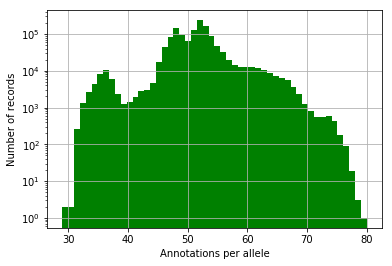

Average annotations per allele = 51.45


In [4]:
# Create a histogram of the number of annotations per allele record.
# We could also use the .nnz attribute of each row, but this way is *much* faster.

apa_hist = [train_x_full.indptr[i+1]-train_x_full.indptr[i] for i in range(train_x_full.shape[0])]
mp.hist(apa_hist,max(apa_hist)-min(apa_hist)+1,facecolor='green')
mp.xlabel('Annotations per allele')
mp.ylabel('Number of records')

# Note the log scale for the y axis!!

mp.yscale('log')
mp.grid(True)
mp.show()

# A fast way to get the average is to take the total number of annotations divided by the number of rows of data

print("Average annotations per allele = {0:.2f}".format(len(train_x_full.data)/train_x_full.shape[0]))


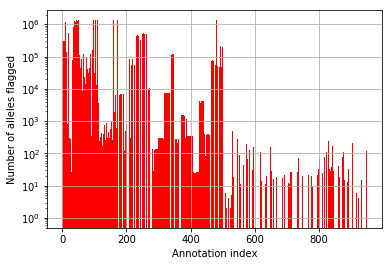

Total nonzero annotations = 633


In [5]:
# Create a histogram out of the raw list of indices

mp.hist(train_x_full.indices,max(train_x_full.indices)-min(train_x_full.indices)+1,facecolor="red")
mp.xlabel('Annotation index')
mp.ylabel('Number of alleles flagged')

# Note the log scale for the y axis!!

mp.yscale('log')
mp.grid(True)
mp.show()
print("Total nonzero annotations =",len(set(train_x_full.indices)))


The first histogram shows that, out of 949 possible annotations for any particular allele, anywhere from 29 - 80 are actually annotated, with over 90% of alleles having from 40 - 60. We could trim the outliers, but this wouldn't improve speed nor accuracy significantly.

In the next histogram, we see that there are about a dozen annotations that appear in almost all the alleles, and on the other hand, a full third of the annotations are never even used. We may wonder if this is due to our subsampling of only 5% of the original dataset, but running the same analysis on the full set only adds 8 more to the total (641 of 949). A couple hundred more are used rather rarely (less than 0.1% of alleles have any of the annotations on the right side of the plot, for example).

To get a better understanding of the dataset, here we show a representation of the model in the CADD paper including all the annotations. Note that this is a Support Vector Machine (SVM), not the deep learning model that was used in DANN or the one that we will implement. A SVM is a linear model that attempts to divide the input into two groups; the variables &alpha;, &beta;, &gamma;, &delta;, and &tau; represent the parameters that define that linear model, so they are not relevant to our exercise. For a full of the first 166 annotations, see <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3992975/bin/NIHMS555958-supplement-1.pdf">tables 1 and 2 here</a>.

<img src="images/cadd1.png" width="700px" alt="model">


The DANN experiment ran on the full 949-dimensional input. However, training that model required 24 hours - a prohibitive amount of time for our purposes. Thus, let's take a moment to clean up the input data before we build the neural network. Efficient and rational data management is the humble hero that often makes the difference between successfully training a model and simply wasting time and computational resources.

Before the lab began, the data were already reduced to a 5% subsample of the original source. We now reduce the data in the other dimension. The best way to do this is to look for those columns (annotations) that are rarely used. If a particular annotation appears only a tiny fraction of the time, removing it can only have a tiny impact on the accuracy of the model, while saving the time and memory used to train weights associated with it.

We define a simple function called `column_reindex` that takes a sparse matrix and a mask - a list of 0's and 1's corresponding to which columns to remove and to keep, respectively - as arguments. <a href="reindex.py">The source code is here.</a> Next, we set a minimum threshold, `rarity_thresh` for how frequently an annotation must be used for it to be kept. By default, this is set to `0.005`, that is, 1 in 200, but you could alter this value to observe its effects. We then remove all columns that have entries occurring less frequently than this, and recreate the histograms above.

10000000 of 68401181 indices counted
20000000 of 68401181 indices counted
30000000 of 68401181 indices counted
40000000 of 68401181 indices counted
50000000 of 68401181 indices counted
60000000 of 68401181 indices counted


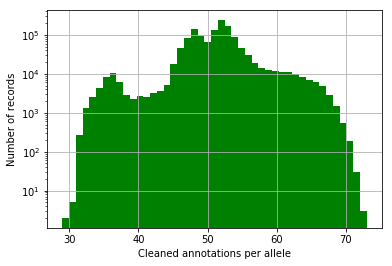

Average annotations per allele = 51.24


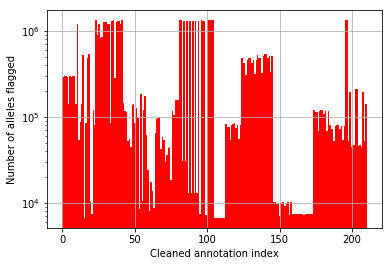

Total annotations remaining = 211


In [6]:
from reindex import reindex_column
filter_mask = [0] * train_x_full.shape[1]       # filter_mask: a list of which columns to keep
rarity_thresh = 0.005                           # rarity_thresh: minimum frequency for annotation to be kept
train_index_count = [0] * train_x_full.shape[1] # train_index_count: raw count of annotations

for k, i in enumerate(train_x_full.indices):
    # Display a progress indicator
    if (k % 10000000 == 0) and k:
        print(k,"of",len(train_x_full.indices),"indices counted")
    train_index_count[i] += 1

for i in range(train_x_full.shape[1]):
    filter_mask[i] = 1 if train_index_count[i]>rarity_thresh*train_x_full.shape[0] else 0

# This step still takes a little time

train_x = reindex_column(train_x_full,filter_mask)

# Save the dimensions of the training data

rows = train_x.shape[0]
cols = train_x.shape[1]

cleaned_hist = [train_x.indptr[i+1]-train_x.indptr[i] for i in range(train_x.shape[0])]
mp.hist(cleaned_hist,max(cleaned_hist)-min(cleaned_hist)+1,facecolor='green')
mp.xlabel('Cleaned annotations per allele')
mp.ylabel('Number of records')
mp.yscale('log')
mp.grid(True)
mp.show()
print("Average annotations per allele = {0:.2f}".format(len(train_x.data)/train_x.shape[0]))

mp.hist(train_x.indices,max(train_x.indices)-min(train_x.indices)+1,facecolor="red")
mp.xlabel('Cleaned annotation index')
mp.ylabel('Number of alleles flagged')
mp.yscale('log')
mp.grid(True)
mp.show()
print("Total annotations remaining =",cols)



With the default setting of `rarity_thresh`, we lose less than one fourth of an annotation on average, while compressing the dimensionality of our dataset by more than three fourths. This will speed up training substantially without sacrificing accuracy.

Let's take a look at the distribution of the actual, numerical values assigned to the remaining data.


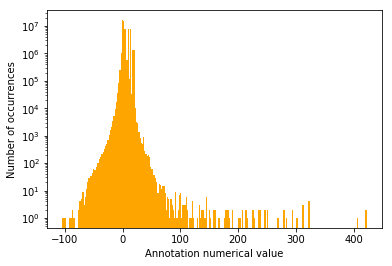

In [7]:
mp.hist(train_x.data,256,facecolor="orange")
mp.yscale('log')
mp.xlabel('Annotation numerical value')
mp.ylabel('Number of occurrences')
mp.show()


While most of the values are clustered around zero, there are some wide tails. These will slow down the training process, as the significance of the larger values is artificially inflated early on. Therefore, we renormalize the dataset so that the values have zero mean and unit variance. There is an exception to this case - sometimes the annotations are set to some constant value or not set at all. We'll set these values to 1 if the annotation occurs and 0 if it is absent.


10000000 of 68131323 annotation values summed
20000000 of 68131323 annotation values summed
30000000 of 68131323 annotation values summed
40000000 of 68131323 annotation values summed
50000000 of 68131323 annotation values summed
60000000 of 68131323 annotation values summed
10000000 of 68131323 annotation values normalized
20000000 of 68131323 annotation values normalized
30000000 of 68131323 annotation values normalized
40000000 of 68131323 annotation values normalized
50000000 of 68131323 annotation values normalized
60000000 of 68131323 annotation values normalized


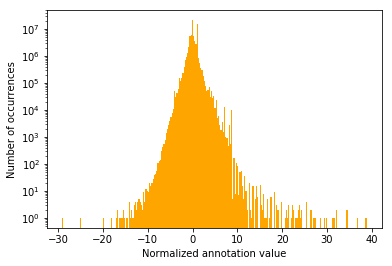

In [8]:
# Compute the averages and standard deviations

avg = [0] * train_x.shape[1]
std = [0] * train_x.shape[1]
count = [0] * train_x.shape[1]
for i in range(len(train_x.data)):
    if (i % 10000000 == 0) and i:
        print(i,"of",len(train_x.data),"annotation values summed")
    avg[train_x.indices[i]] += train_x.data[i]
    std[train_x.indices[i]] += train_x.data[i] * train_x.data[i]
    count[train_x.indices[i]] += 1
for i in range(train_x.shape[1]):
    avg[i] /= count[i] # x /= 3 is equivalent to x = x / 3
    std[i] = std[i] / count[i] - avg[i]*avg[i]
    std[i] = 0. if std[i] < 1e-9 else std[i]   # Fixes rounding error on constant-valued annotations
std = np.sqrt(std)    # Computes SD from Variance

# Normalize the data
for i in range(len(train_x.data)):
    if (i % 10000000 == 0) and i:
        print(i,"of",len(train_x.data),"annotation values normalized")
    if std[train_x.indices[i]]:     # if the annotation has multiple possible values, mean = 0, std dev = 1
        train_x.data[i] = (train_x.data[i] - avg[train_x.indices[i]]) / std[train_x.indices[i]]
        if abs(train_x.data[i]) > 100:  # there are a handful of outliers that are likely errors in the original data
            train_x.data[i] = 0.
    else:
        train_x.data[i] = 1.

# Replot the histogram
mp.hist(train_x.data,256,facecolor="orange")
mp.yscale('log')
mp.xlabel('Normalized annotation value')
mp.ylabel('Number of occurrences')
mp.show()
    

Next, we load the validation and test datasets and apply the same transformations to them. Note that it is necessary to use the same `filter_mask` as before so that the data are fed into the model in a consistent way.


In [9]:
# Load and normalize the validation data

with np.load(os.path.join(data_dir,"validation.X.reduced.npz")) as temp:
    valid_x_full = ss.csr_matrix((temp['data'],temp['indices'],temp['indptr']),shape=temp['shape'])
    valid_x = reindex_column(valid_x_full,filter_mask)
for i in range(len(valid_x.data)):
    if std[valid_x.indices[i]]:
        valid_x.data[i] = (valid_x.data[i] - avg[valid_x.indices[i]]) / std[valid_x.indices[i]]
        if abs(valid_x.data[i]) > 100:
            valid_x.data[i] = 0.
    else:
        valid_x.data[i] = 1.
        
print("Validation data loaded and normalized")

# Load and normalize the test data
    
with np.load(os.path.join(data_dir,"testing.X.reduced.npz")) as temp:
    test_x_full = ss.csr_matrix((temp['data'],temp['indices'],temp['indptr']),shape=temp['shape'])
    test_x = reindex_column(test_x_full,filter_mask)
for i in range(len(test_x.data)):
    if std[test_x.indices[i]]:
        test_x.data[i] = (test_x.data[i] - avg[test_x.indices[i]]) / std[test_x.indices[i]]
        if abs(test_x.data[i]) > 100:
            test_x.data[i] = 0.
    else:
        test_x.data[i] = 1.

print("Test data loaded and normalized")

Validation data loaded and normalized
Test data loaded and normalized


With the annotations (the input, or x, values) loaded, cleaned, and transformed, we turn our attention to the classification (the output, or y, values). This code block opens the file containing these values, enumerates the distinct possibilities, and counts the occurrences of each. It also loads the validation and test y data.

Lastly, the matrices we have constructed are converted into PyTorch tensors and then moved onto the GPU for a dramatic improvement in training time.

In [10]:
# aan .npy file is a single array, so we can just load it into a list

train_y = np.load(os.path.join(data_dir,"training.y.reduced.npy"))

# Gather only the unique values of y

yset = set(train_y)
ycount = [0] * len(yset)

# Convert back to a list to use the index method

yset = list(yset)
print("The distinct y values are",yset)

# Count each element of ydata

for j in train_y:
    ycount[yset.index(j)] += 1
print("The counts for each of these are", ycount)

# Load validation and test sets

valid_y = np.load(os.path.join(data_dir,"validation.y.reduced.npy"))
test_y = np.load(os.path.join(data_dir,"testing.y.reduced.npy"))

# Convert all the data into PyTorch tensors, and move them to the GPU for acceleration

train_x_tensor = torch.from_numpy(train_x.toarray()).float().to(dev)
train_y_tensor = torch.from_numpy(train_y).to(dev)
valid_x_tensor = torch.from_numpy(valid_x.toarray()).float().to(dev)
valid_y_tensor = torch.from_numpy(valid_y).to(dev)
test_x_tensor = torch.from_numpy(test_x.toarray()).float().to(dev)
test_y_tensor = torch.from_numpy(test_y).to(dev)

The distinct y values are [0, 1]
The counts for each of these are [664030, 665502]


Thus, we see the y values are 0 and 1, corresponding to the two types of genes annotated in our data set -- simulated and real. They are roughly equal in number; this helps to keep the training from being biased toward one answer over the other. This also suggests the use of a <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> activation function, which ranges from 0 to 1, for the output layer of the deep network. This function maps a set of raw scores to a list of probability scores (that is, numbers between 0 and 1 that sum to 1). Note that a two node softmax is equivalent to a single node <a href="https://en.wikipedia.org/wiki/Sigmoid_function">sigmoid</a> activation, but we use softmax for convenience.


## Deep learning

A quick review of the fundamentals is in order. This model uses a feed forward neural network, shown in reduced size below.
<img src="images/ffnn.png" alt="feedforward NN" style="width: 500px;"/>
The layers are connected by edges (or weights). Each node in the subsequent layer has a different weight associated with every node in the previous layer. These weighted values are summed, with the activation function applied to the result to introduce nonlinearity. The input layer consists of the reduced set of annotations we've been working with, and the output layer is just two nodes with the calculated probability of the allele being simulated or real, respectively.

The learning occurs as the weights are adjusted to minimize the error between the prediction of the model and the actual y values of the training data. The number of layers, nodes per layer, activation functions, and so forth are hyperparameters that we can adjust by hand to improve our model.

We consider the number of parameters per layer. Each node in the ouput (or outgoing hidden) layer has a weight associated with each node in the input (or incoming hidden) layer, plus a single bias value added to the sum at the output node. If the input layer has M nodes and the output has N, then the number of weights is M &times; N, and the number of biases required is N (one for each output node). This makes for a total of M &times; N + N variables, each of which requires a separate computation at each training step to evaluate how it affects the final loss. Thus, with multiple layers, the computation time is roughly quadratic in the size of each layer.


In the original DANN model, we have 949 annotations in each allele as input, with 3 hidden layers of 1000 nodes and an output layer of 2 nodes. This makes for a total of:

(949 &times; 1000 + 1000) + (1000 &times; 1000 + 1000) + (1000 &times; 1000 + 1000) + (1000 &times; 2 + 2) = 2,954,002 variables to be determined in the model.

#### Question 1
With a reduced input of 200 annotations, a more compact model with 100, 30, and 10 node hidden layers, and the same 2 node output, how many variables must the algorithm optimize? 

In [18]:
print((200*100+100) + (100*30+30)+(30*10+10)+(10*2+2),'is a correct hit!')


23462 is a correct hit!


<a href="not_a_solution_key.txt">Solution</a>

The next cell defines a model architecture. The parameters in the model can be set at your discretion, as described in the comments. By default, there are 3 hidden layers, but the number of nodes in each layer has been reduced relative to the DANN model. You can easily adjust these parameters as specified in the comments in the code and see the results.


In [19]:
help('super')

Help on class super in module builtins:

class super(object)
 |  super() -> same as super(__class__, <first argument>)
 |  super(type) -> unbound super object
 |  super(type, obj) -> bound super object; requires isinstance(obj, type)
 |  super(type, type2) -> bound super object; requires issubclass(type2, type)
 |  Typical use to call a cooperative superclass method:
 |  class C(B):
 |      def meth(self, arg):
 |          super().meth(arg)
 |  This works for class methods too:
 |  class C(B):
 |      @classmethod
 |      def cmeth(cls, arg):
 |          super().cmeth(arg)
 |  
 |  Methods defined here:
 |  
 |  __get__(self, instance, owner, /)
 |      Return an attribute of instance, which is of type owner.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new obje

In [11]:
class binary_classifier(nn.Module):
    def __init__(self,input_size=949): # Default input_size is 949, but we will use the new size when creating the model
        super(binary_classifier,self).__init__()
        
        # This section of code contains the size of each layer, as well as the number of layers
        # As long as: the first layer has input of size "input_size",
        #             each hidden layer has the same size input as the previous layer's output,
        #             and the final layer has a size of 2,
        # you can adjust and alter these parameters and experiment on the results.
        
        self.hidden1 = nn.Linear(input_size,70)
        self.hidden2 = nn.Linear(70,24)
        self.hidden3 = nn.Linear(24,8)
        self.final = nn.Linear(8,2)
        
        # The use of dropout layers is optional, and the dropout probability could be altered
        # Try without, with weak, and with strong dropout, and see how the training results are affected.
        
        self.drop1 = nn.Dropout(p=0.125)
        self.drop2 = nn.Dropout(p=0.0625)
        
    def forward(self,x):
        
        # If the number of layers in the __init__ method above is changed, this code will need to be modified.
        
        x = self.hidden1(x)   # Pass the input to the first hidden layer
        x = fun.elu(x)        # Apply activation (elu, could try another function, such as tanh)
        x = self.drop1(x)     # Apply first dropout layer
        x = self.hidden2(x)   # Pass results to second hidden layer
        x = fun.elu(x)        # Apply activation (elu)
        x = self.drop2(x)     # Apply second dropout layer
        x = self.hidden3(x)   # Pass results to third hidden layer
        x = fun.elu(x)        # Apply activation (elu)
        x = self.final(x)     # Pass to output
        return x


    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


We create a specific model using the architecture defined above. If you wish to restart training on a fresh model, you must re-run this cell.

In [12]:
model = binary_classifier(input_size = cols).to(dev)

The hyperparameters are defined below. They can also be adjusted. The maximum number of epochs is set relatively small to allow for short initial test trainings. Once model architecture, learning rate, and batch size, in particular, are optimized, you should turn up the epochs to several thousand and run a longer training session before proceeding.


In [13]:
lr = 0.25                # Set the learning rate. Too high of a learning rate causes instability; too low takes too long
lr_decay = 0.875         # If the validation loss starts to increase, decay the learning rate
max_epoch = 501          # Maximum training epochs
batch_size = 100000      # This batch size runs at the same speed as smaller ones, but you can compare to other values.
num_bats = -(-rows // batch_size) # Quick way to round up instead of down when figuring out how many batches are needed 
eval_steps = 100         # Evaluate the validation loss every N epochs.
v2t_loss_ratio = 1.25    # If the validation loss is higher than the training loss by this factor, stop.

This cell trains the model. It uses the validation set for comparison purposes, and attempts to prevent overtraining by decaying the learning rate if the validation loss stops decreasing. It implements batches in a simple way, and the shuffling of these batches could be turned off, if one wanted to investigate the change in speed vs. accuracy.



In [14]:
start = time.time()
opti = om.SGD(model.parameters(), lr = lr)   # Initialize an optimizer on the model's parameters
lossfun = nn.CrossEntropyLoss()              # Specify the final loss function
model.train()                                # Puts the model in training mode (relevant to batchnorm and dropout layers)
running_avg_length = 3                       # If the validation loss increases over the average of the past N models,
old_valid_loss = [99.] * running_avg_length  #   then decrease the learning rate by lr_decay.

for i in range(max_epoch):
    epoch_loss = 0.
    permute = torch.randperm(rows)           # These lines are a relatively painless way to shuffle the training batches.
    train_x_tensor = train_x_tensor[permute] # Commenting these 3 lines out speeds up the training by about 30%,
    train_y_tensor = train_y_tensor[permute] # but it has a negative impact on the final accuracy.
    for j in range(num_bats):
        opti.zero_grad()
        y_out = model(train_x_tensor[j*batch_size:(j+1)*batch_size,])   # pass the batch of data through the model
        loss = lossfun(y_out, train_y_tensor[j*batch_size:(j+1)*batch_size])  # compute the loss compared to 
        if j == num_bats - 1 and rows % batch_size:        # If we are on the last batch, and batches don't divide evenly,
            loss = loss * (rows % batch_size) / batch_size # then we should reduce the loss so the batch has less effect
        epoch_loss += loss.item()   # Convert the batch loss into a scalar and add it to the running total
        loss.backward()      # Back prop
        opti.step()          # Take a step with the optimizer
    
    # Calculate validation loss every eval_steps epochs.
        
    if i % eval_steps == 0:
        epoch_loss *= batch_size / rows  # rescale epoch loss
        model.eval()
        with torch.no_grad():
            y_out = model(valid_x_tensor)
            valid_loss = lossfun(y_out, valid_y_tensor).item()
        print("Epoch:", i, "Loss:",epoch_loss, "Validation loss:", valid_loss)
        if valid_loss > sum(old_valid_loss)/running_avg_length:  # compare the validation loss to its running average
            lr *= lr_decay
            print("Learning rate decaying to:",lr)
            opti = om.SGD(model.parameters(), lr = lr)   # restart optimizer with new LR
        for k in range(running_avg_length - 1):
            old_valid_loss[k] = old_valid_loss[k+1]      # update list of old validation losses
        old_valid_loss[-1] = valid_loss 
        if valid_loss > v2t_loss_ratio * epoch_loss:
            break        # If the validation loss is too high, overtraining is occurring, break.
        model.train()
print("Training time:",time.time() - start)

Epoch: 0 Loss: 0.6980659641457927 Validation loss: 0.6887145638465881
Epoch: 100 Loss: 0.6677442016867623 Validation loss: 0.6635018587112427
Epoch: 200 Loss: 0.6641260962961938 Validation loss: 0.6604481339454651
Epoch: 300 Loss: 0.661014223676684 Validation loss: 0.6583483219146729
Epoch: 400 Loss: 0.6578885049109072 Validation loss: 0.6573440432548523
Epoch: 500 Loss: 0.6551970422678748 Validation loss: 0.6574323773384094
Training time: 78.73168969154358


Because the validation dataset was used to adjust the learning rate, we use the independent test dataset to measure the accuracy of the model.


In [21]:
model.eval()
with torch.no_grad():
    y_out = model(test_x_tensor)
    pred = y_out.max(1,keepdim=True)[1]
    pred = pred.to(dev)
    correct = pred.eq(test_y_tensor.view_as(pred)).sum().item()
print(correct,"of",test_y.shape[0],"=",correct/test_y.shape[0],"accuracy")


99736 of 166091 = 0.6004900927804637 accuracy


## ROC curve
<img src="images/roc.png" alt="Header" style="width: 500px;"/>
The ROC curve is one of several measures of the accuracy of the model. As we lower the numerical threshold to consider an allele to be pathogenic, we will increase both the number of true and false positives. The ROC curve is simply a plot of the true positive rate plotted as a function of the false positive rate. As long as the probability of catching a true positive exceeds that of picking a false one, our model has an edge on random guessing. The area under the curve (AUC) quantifies how much of an edge.

Here we will plot the ROC curve for our model and compute its AUC. The previous accuracy measure uses a threshold value of 0.5 for a positive prediction. However, we could shift this threshold and trade sensitivity for specificity - that is, setting a lower threshold will increase both the true and false positive rates. We calculate and then plot the ROC below. Note that a y value of 0 corresponds to a positive value.

In [22]:
softmax = nn.Softmax(dim=1)   # defines the softmax function for evaluation here
roc_step = 1/64   # step size for threshold
# ROC for training set
pos_train = 0
for i in range(rows):
    if train_y[i] == 0:
        pos_train += 1
neg_train = rows - pos_train

# list of x and y coordinates
train_roc_x = []
train_roc_y = []

y_out = softmax(model(train_x_tensor)).tolist()
y_real = train_y_tensor.tolist()

# vary the threshold value
for thresh in np.arange(0,1.,roc_step):
    tp = 0 # true positive count at this threshold value
    fp = 0 # false positive count
    for i in range(rows):
        if y_out[i][0] > thresh: # positive detection
            # now see if it is a true or false positive
            if y_real[i] == 0:
                tp += 1
            else:
                fp += 1
                
# Convert these to rates and add them to the x and y lists    
    train_roc_x.append(fp/neg_train)
    train_roc_y.append(tp/pos_train)

# Repeat for test set
pos_test = 0
for i in range(len(test_y)):
    if test_y[i] == 0:
        pos_test += 1
neg_test = len(test_y) - pos_test

# list of x and y coordinates
test_roc_x = []
test_roc_y = []

y_out = softmax(model(test_x_tensor)).tolist()
y_real = test_y_tensor.tolist()

# vary the threshold value
for thresh in np.arange(0,1.,roc_step):
    tp = 0 # true positive count at this threshold value
    fp = 0 # false positive count
    for i in range(len(test_y)):
        if y_out[i][0] > thresh: # positive detection
            # now see if it is a true or false positive
            if y_real[i] == 0:
                tp += 1
            else:
                fp += 1
                
# Convert these to rates and add them to the x and y lists    
    test_roc_x.append(fp/neg_test)
    test_roc_y.append(tp/pos_test)


Let's see how these ROC curves look. Keep in mind that we're competing against the DANN model pictured here. Click the image for a link to the higher performing MVP paper as well. These graphs have been split into two - genes which are likely intolerant to a loss of function mutation, as determined by their pLI (probability of loss intolerance) score, and hence constrained, and those which are not thus constrained.

The main takeaway is that it is difficult to distinguish the simulated alleles from the real ones, and hence, despite quantitatively lackluster accuracy (your model is unlikely to surpass 2/3 accuracy), the quick and simple deep learning model we prepared in our mini-experiment here is competitive with the state-of-the-art linear classifier models of just a few years ago.

<a href="https://www.biorxiv.org/content/biorxiv/early/2018/02/02/259390.full.pdf"><img src="images/doubleroc.png" style="width:500 px;"/></a>

#### Question 2
Regarding the figures above, what algorithm appears to be the best based on the area under the ROC curve? How does DANN fare compared to the state of the art methods?



Go ahead and plot your ROC to compare to those above.

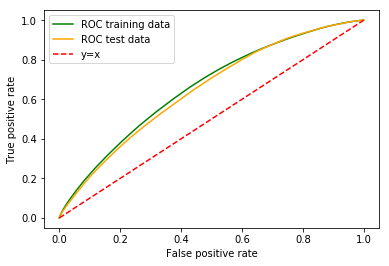

In [23]:
mp.plot(train_roc_x, train_roc_y, color = 'green', label = 'ROC training data')
mp.plot(test_roc_x, test_roc_y, color = 'orange', label = 'ROC test data')
mp.plot([0,1],[0,1], color = 'red', linestyle = 'dashed', label = 'y=x')
mp.xlabel('False positive rate')
mp.ylabel('True positive rate')
mp.legend()
mp.show()


If you're up for it, calculate the area under the curve for each. Remember that the formula for the trapezoid rule is,
$$A = \sum_i \frac{y_{i+1}+y_i}{2}\times|x_{i+1}-x_i|$$.

In [24]:
train_auc = 0
for i in range(len(train_roc_x)-1):
    train_auc += ## FIX ME: Complete the formula for the trapezoid rule ##

test_auc = 0
for i in range(len(test_roc_x)-1):
    test_auc += ## FIX ME: Complete the formula for the trapezoid rule ##

print("Training AUC =",train_auc)
print("Test AUC =",test_auc)


SyntaxError: invalid syntax (<ipython-input-24-8061558cd579>, line 3)

<a href="soln.ipynb">Code solution</a>

## Next steps

From here, it's only a relatively short jump to improving on the state of the art in genomics. You can easily continue on with the work started in this lab.

<ul>
    <li>Download a copy of this notebook to save your work.</li>
    <li>Download PyTorch, Tensorflow, or another deep learning framework. The code is easily adapted to other deep learning frameworks.</li>
    <li><a href="https://cbcl.ics.uci.edu/public_data/DANN/">Download the DANN datasets.</a></li>
    <li>Continue to improve and train models. See if you can beat the state of the art.</li>
    <li>Try using convolutional or other network architectures.</li>
</ul>